# Import libraries and load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold,StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
!pip install catboost --quiet
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, normalize, StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
import time
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 65.7MB 50kB/s 


In [2]:
!git clone https://github.com/rijulb17/Job_A_Thon_AV_hackathon.git

Cloning into 'Job_A_Thon_AV_hackathon'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [3]:
df = pd.read_csv("/content/Job_A_Thon_AV_hackathon/train.csv")
test = pd.read_csv("/content/Job_A_Thon_AV_hackathon/test.csv")

# EDA and Data Cleaning

In [4]:
df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3,1.0,16,10404.0,0


In [5]:
df.describe()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
count,50882.000000,50882.000000,50882.000000,50882.000000,30631.000000,50882.000000,50882.000000,50882.000000
mean,25441.500000,1732.788707,44.856275,42.738866,2.439228,15.115188,14183.950069,0.239947
std,14688.512535,1424.081652,17.310271,17.319375,1.025923,6.340663,6590.074873,0.427055
min,1.000000,1.000000,18.000000,16.000000,1.000000,1.000000,2280.000000,0.000000
25%,12721.250000,523.000000,28.000000,27.000000,1.000000,12.000000,9248.000000,0.000000
50%,25441.500000,1391.000000,44.000000,40.000000,3.000000,17.000000,13178.000000,0.000000
75%,38161.750000,2667.000000,59.000000,57.000000,3.000000,20.000000,18096.000000,0.000000
max,50882.000000,6194.000000,75.000000,75.000000,4.000000,22.000000,43350.400000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

In [7]:
total_feats = df.columns

Visuallisations

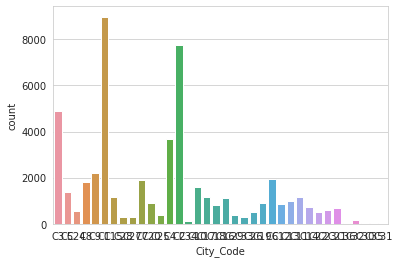

In [8]:
sns.countplot(df.City_Code);

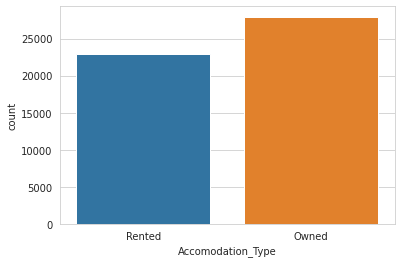

In [9]:
sns.countplot(df.Accomodation_Type)

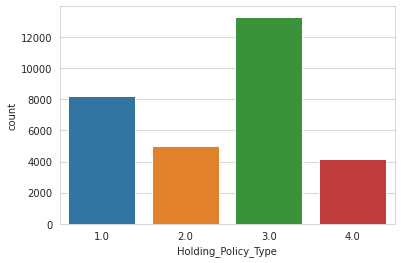

In [10]:
sns.countplot(df.Holding_Policy_Type)

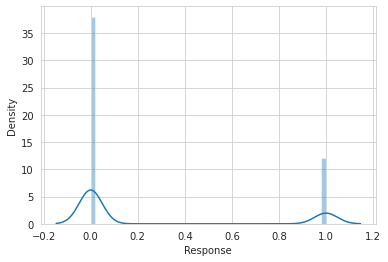

In [11]:
sns.distplot(df.Response)

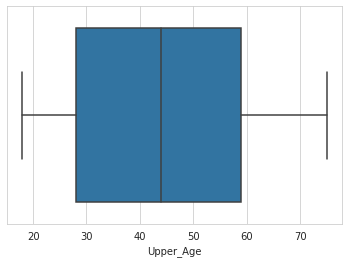

In [12]:
sns.boxplot(df.Upper_Age)

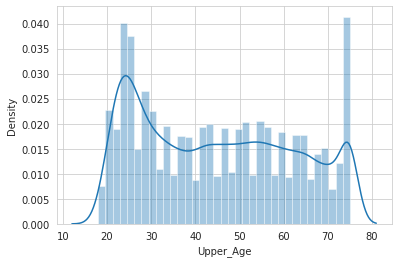

In [13]:
sns.distplot(df.Upper_Age)

In [14]:
# To have more normal distribution

from sklearn.preprocessing import QuantileTransformer
u_age = df.Upper_Age.values.reshape(-1,1)
qt = QuantileTransformer(n_quantiles = 10, output_distribution ='normal', random_state = 0)
u_age_norm = qt.fit_transform(u_age)

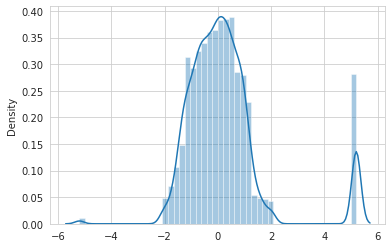

In [15]:
sns.distplot(u_age_norm)

There are outliers in the age feature.

In [16]:
# For handling missing values and encoding

def cleaning_df(data):
    #handling missing values
    data.Holding_Policy_Duration = data.Holding_Policy_Duration.replace(np.nan,0)
    data.Holding_Policy_Type = data.Holding_Policy_Type.fillna(0)
    data['Health Indicator'] = data['Health Indicator'].replace(np.nan,'X0') 
    
    #encoding for binary features
    le = LabelEncoder() 
    data['Accomodation_Type']= le.fit_transform(data['Accomodation_Type']) 
    data['Reco_Insurance_Type']= le.fit_transform(data['Reco_Insurance_Type']) 
    data['Is_Spouse']= le.fit_transform(data['Is_Spouse']) 
    
    #onehotencoding for nominal feature
    data = pd.get_dummies(data, prefix = ['H_Policy_Type'], columns = ['Holding_Policy_Type']) 
    
    #frequency encoding
    Health_fq = data.groupby('Health Indicator').size()/len(data)
    data.loc[:, "{}_freq_encode".format('Health Indicator')] = data['Health Indicator'].map(Health_fq)   
    data = data.drop(['Health Indicator'], axis = 1)
    
    City_Code_fq = data.groupby('City_Code').size()/len(data)
    data.loc[:, "{}_freq_encode".format('City_Code')] = data['City_Code'].map(City_Code_fq)   
    data = data.drop(['City_Code'], axis = 1)
    
    #ordinal encoding
    data['Holding_Policy_Duration'] = data.Holding_Policy_Duration.astype(str)
    oe = OrdinalEncoder()  
    oe.fit([data['Holding_Policy_Duration']]) 
    data["Holding_Policy_Duration"]= oe.fit_transform(data[["Holding_Policy_Duration"]])
    
    return data

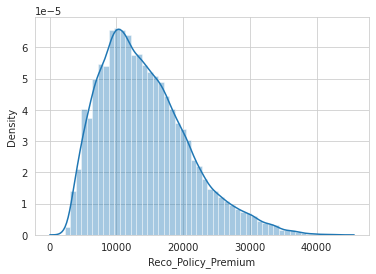

In [17]:
sns.distplot(df.Reco_Policy_Premium);

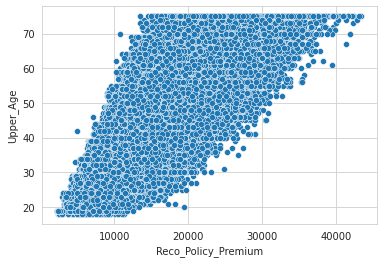

In [18]:
sns.scatterplot(df.Reco_Policy_Premium,df.Upper_Age);

In [19]:
df.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

In [20]:
df = cleaning_df(df)
test = cleaning_df(test)

In [21]:
df.head()

,ID,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Reco_Policy_Cat,Reco_Policy_Premium,Response,H_Policy_Type_0.0,H_Policy_Type_1.0,H_Policy_Type_2.0,H_Policy_Type_3.0,H_Policy_Type_4.0,Health Indicator_freq_encode,City_Code_freq_encode
0,1,3213,1,0,36,36,0,7.0,22,11628.0,0,0,0,0,1,0,0.255690,0.096085
1,2,1117,0,1,75,22,0,0.0,22,30510.0,0,1,0,0,0,0,0.203058,0.026807
2,3,3732,0,0,32,32,0,1.0,19,7450.0,1,0,1,0,0,0,0.229767,0.026807
3,4,4378,0,1,52,48,0,7.0,19,17780.0,0,0,0,0,1,0,0.255690,0.010868
4,5,2190,1,0,44,44,0,9.0,16,10404.0,0,0,1,0,0,0,0.203058,0.035494


In [22]:
df = pd.get_dummies(df, prefix = ['Reco_pol_cat'], columns = ['Reco_Policy_Cat']) 
test = pd.get_dummies(test, prefix = ['Reco_pol_cat'], columns = ['Reco_Policy_Cat'])

In [23]:
df.head()

,ID,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Holding_Policy_Duration,Reco_Policy_Premium,Response,H_Policy_Type_0.0,H_Policy_Type_1.0,H_Policy_Type_2.0,H_Policy_Type_3.0,H_Policy_Type_4.0,Health Indicator_freq_encode,City_Code_freq_encode,Reco_pol_cat_1,Reco_pol_cat_2,Reco_pol_cat_3,Reco_pol_cat_4,Reco_pol_cat_5,Reco_pol_cat_6,Reco_pol_cat_7,Reco_pol_cat_8,Reco_pol_cat_9,Reco_pol_cat_10,Reco_pol_cat_11,Reco_pol_cat_12,Reco_pol_cat_13,Reco_pol_cat_14,Reco_pol_cat_15,Reco_pol_cat_16,Reco_pol_cat_17,Reco_pol_cat_18,Reco_pol_cat_19,Reco_pol_cat_20,Reco_pol_cat_21,Reco_pol_cat_22
0,1,3213,1,0,36,36,0,7.0,11628.0,0,0,0,0,1,0,0.255690,0.096085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1117,0,1,75,22,0,0.0,30510.0,0,1,0,0,0,0,0.203058,0.026807,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3,3732,0,0,32,32,0,1.0,7450.0,1,0,1,0,0,0,0.229767,0.026807,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,4,4378,0,1,52,48,0,7.0,17780.0,0,0,0,0,1,0,0.255690,0.010868,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,5,2190,1,0,44,44,0,9.0,10404.0,0,0,1,0,0,0,0.203058,0.035494,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [24]:
# To check the distribution of Response variable

print("There are {}% target values with 1".format(100 * df["Response"].value_counts()[1]/df.shape[0]))

There are 23.99473291144216% target values with 1


In [25]:
#min_max_scaler = MinMaxScaler()
#np_scaled = min_max_scaler.fit_transform(X_train)
#X_train = pd.DataFrame(np_scaled)

#np_scaled = min_max_scaler.fit_transform(X_test)
#X_test = pd.DataFrame(np_scaled)

# Modeling

In [26]:
X = df.drop(['ID','Response'],axis =1)
Y = df['Response'].values

In [27]:
X_test = test.drop(['ID'], axis =1)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.30, random_state = 42)

In [29]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((35617, 37), (35617,), (15265, 37), (15265,))

In [30]:
def classify(model,X_tr,y_tr,X_t,X_v,y_v):
  # Scaling 
  #scaler = MinMaxScaler()
  #np_scaled = scaler.fit_tranform(X_tr)
  #X_tr = pd.DataFrame(np_scaled)
  #X_tr = scaler.fit_tranform(X_tr)
  #X_t  = scaler.fit_tranform(X_t)
  #X_v   = scaler.fit_tranform(X_v)

  # Model fit and accuracy on validation set calculation
  model.fit(X_tr,y_tr)
  y_v_pred_probs  = model.predict_proba(X_v)[:,1]
  y_v_pred_values = model.predict(X_v)
  #acc_score_v = accuracy_score(y_v,y_v_pred_values)
  #print(acc_score_v)

  roc_score_v = roc_auc_score(y_v,y_v_pred_probs)
  #print(roc_score_v)

  #f1_scores_v = cross_val_score(model, X_v, y_v, cv=5, scoring='f1')
  #print("F1-score = ",f1_scores_v," Mean F1 score = ",np.mean(f1_scores_v)) 

  # To get predictions on X_test
  #y_prob = model.predict_proba(X_test)[:,1]

  return roc_score_v #, y_prob


XBG without hypertuning on unnormalised data

In [31]:
xgb_auc_score = classify(XGBClassifier(), X_train, y_train, X_test, X_val, y_val)

LGBM 

In [32]:
lgbm_auc_score = classify(LGBMClassifier(), X_train, y_train, X_test, X_val, y_val )

Logistic Regression

In [33]:
lr_auc_score = classify(LogisticRegression(),  X_train, y_train, X_test, X_val, y_val)

Decision tree

In [34]:
dt_auc_score = classify(DecisionTreeClassifier(criterion='entropy') , X_train, y_train, X_test, X_val, y_val )

Random Forest

In [35]:
rf_auc_score = classify(RandomForestClassifier(n_estimators=100), X_train, y_train, X_test, X_val, y_val )

GBM

In [36]:
gbm_auc_score = classify(GradientBoostingClassifier(), X_train, y_train, X_test, X_val, y_val)

###Simple Catboost

In [37]:
cat_auc_score = classify(CatBoostClassifier(), X_train, y_train, X_test, X_val, y_val)

Learning rate set to 0.047369
0:	learn: 0.6787154	total: 67.3ms	remaining: 1m 7s
1:	learn: 0.6629474	total: 83.7ms	remaining: 41.8s
2:	learn: 0.6484545	total: 100ms	remaining: 33.2s
3:	learn: 0.6383455	total: 117ms	remaining: 29.1s
4:	learn: 0.6292676	total: 134ms	remaining: 26.6s
5:	learn: 0.6208379	total: 150ms	remaining: 24.9s
6:	learn: 0.6117395	total: 166ms	remaining: 23.6s
7:	learn: 0.6048972	total: 183ms	remaining: 22.7s
8:	learn: 0.5979711	total: 202ms	remaining: 22.2s
9:	learn: 0.5922384	total: 219ms	remaining: 21.7s
10:	learn: 0.5870580	total: 236ms	remaining: 21.2s
11:	learn: 0.5824654	total: 252ms	remaining: 20.7s
12:	learn: 0.5781055	total: 268ms	remaining: 20.4s
13:	learn: 0.5743277	total: 285ms	remaining: 20.1s
14:	learn: 0.5707911	total: 304ms	remaining: 20s
15:	learn: 0.5673090	total: 320ms	remaining: 19.7s
16:	learn: 0.5642433	total: 336ms	remaining: 19.5s
17:	learn: 0.5614695	total: 353ms	remaining: 19.2s
18:	learn: 0.5590196	total: 370ms	remaining: 19.1s
19:	learn: 

##Catboost Tuned - new

In [39]:
cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         classes_count=2,
                         depth=10,
                         random_seed=121, 
                         iterations=1000, 
                         learning_rate=0.1,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         border_count=100,
                         od_wait=500)
cat.fit(X_train, y_train, verbose=100,
        use_best_model=True,
        eval_set=[(X_train, y_train),(X_val, y_val)],
        plot=False)
predictions = cat.predict(X_val)
print('accuracy:', f1_score(y_val, predictions, average='binary') )

0:	learn: 0.6596466	test: 0.6596466	test1: 0.6524946	best: 0.6524946 (0)	total: 54ms	remaining: 53.9s
100:	learn: 0.6885990	test: 0.6885990	test1: 0.6588042	best: 0.6591585 (99)	total: 4.85s	remaining: 43.2s
200:	learn: 0.7432092	test: 0.7432092	test1: 0.6649887	best: 0.6654241 (192)	total: 9.85s	remaining: 39.1s
300:	learn: 0.7952232	test: 0.7952232	test1: 0.6708490	best: 0.6708490 (300)	total: 14.8s	remaining: 34.4s
400:	learn: 0.8346503	test: 0.8346503	test1: 0.6751055	best: 0.6751055 (400)	total: 19.8s	remaining: 29.6s
500:	learn: 0.8684988	test: 0.8684988	test1: 0.6767894	best: 0.6767894 (500)	total: 24.8s	remaining: 24.7s
600:	learn: 0.8953444	test: 0.8953444	test1: 0.6779176	best: 0.6783255 (589)	total: 29.8s	remaining: 19.8s
700:	learn: 0.9154176	test: 0.9154176	test1: 0.6789394	best: 0.6792277 (647)	total: 34.8s	remaining: 14.9s
800:	learn: 0.9330314	test: 0.9330314	test1: 0.6802521	best: 0.6818086 (752)	total: 39.9s	remaining: 9.91s
900:	learn: 0.9469105	test: 0.9469105	test1

In [40]:
pred_prob = cat.predict_proba(X_val)
cat_auc_score_new = roc_auc_score(y_val,pred_prob[:,1])
cat_auc_score_new

0.6263031347332932

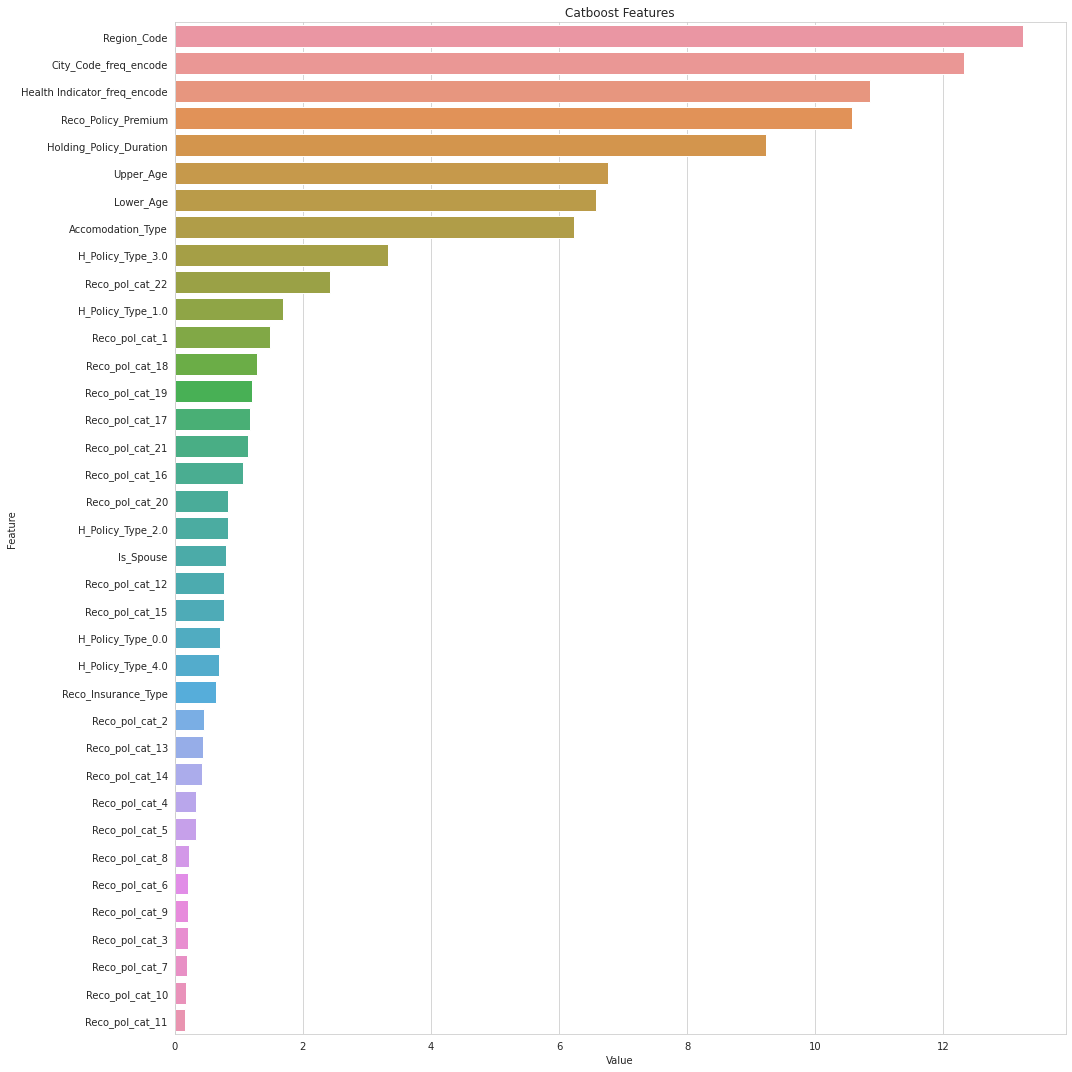

In [43]:
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

# Catboost

In [44]:
train_copy = pd.read_csv("/content/Job_A_Thon_AV_hackathon/train.csv")
test_copy = pd.read_csv("/content/Job_A_Thon_AV_hackathon/test.csv")

In [45]:
train_copy.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3,1.0,16,10404.0,0


In [46]:
test_df = test_copy
train_df = train_copy

In [47]:
train_df = train_df.drop(['ID'], axis =1)
test_df = test_df.drop(['ID'], axis =1)
x=[]
for i in test_df.columns:
  x.append(i)
x=np.array(x)
x

array(['City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration',
       'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium'],
      dtype='<U23')

In [48]:
# To Keep only Categorical features 
index_to_del = [4,5,11]

In [49]:
x = np.delete(x,index_to_del)

In [50]:
categorical_feats = x

In [56]:
# To have all categorical features in string format
for i in x:
  train_df[i] = train_df[i].astype('str')
  test_df[i] = test_df[i].astype('str')

In [65]:
cat_raw =CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         classes_count=2,
                         depth=10,
                         random_seed=121, 
                         iterations=1000, 
                         learning_rate=0.1,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         border_count=100,
                         od_wait=500)

In [66]:
X_t = train_df.drop(['Response'], axis =1)
y_t = train_df['Response'].values
X_te = test_df

In [67]:
cat_raw.fit(X_t, y_t, cat_features=categorical_feats,
        use_best_model=True)


You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.6628815	total: 362ms	remaining: 6m 2s
1:	learn: 0.6596318	total: 679ms	remaining: 5m 38s
2:	learn: 0.6598622	total: 997ms	remaining: 5m 31s
3:	learn: 0.6578754	total: 1.3s	remaining: 5m 23s
4:	learn: 0.6576432	total: 1.57s	remaining: 5m 12s
5:	learn: 0.6577900	total: 1.87s	remaining: 5m 9s
6:	learn: 0.6568544	total: 1.9s	remaining: 4m 30s
7:	learn: 0.6570407	total: 2.26s	remaining: 4m 40s
8:	learn: 0.6566681	total: 2.37s	remaining: 4m 20s
9:	learn: 0.6569942	total: 2.68s	remaining: 4m 25s
10:	learn: 0.6580049	total: 2.98s	remaining: 4m 27s
11:	learn: 0.6599905	total: 3.25s	remaining: 4m 27s
12:	learn: 0.6619429	total: 3.54s	remaining: 4m 29s
13:	learn: 0.6667684	total: 3.87s	remaining: 4m 32s
14:	learn: 0.6717093	total: 4.15s	remaining: 4m 32s
15:	learn: 0.6768545	total: 4.42s	remaining: 4m 31s
16:	learn: 0.6811074	total: 4.79s	remaining: 4m 37s
17:	learn: 0.6845795	total: 5.07s	remaining: 4m 36s
18:	learn: 0.6879684	total: 5.35s	remaining: 4m 36s
19:	learn: 0.6923535	total

In [68]:
y_pro_cat_raw = cat_raw.predict_proba(X_te)[:,1]

In [69]:
y_prob = np.array( y_pro_cat_raw )

submission = pd.DataFrame({
        "ID": test["ID"],
        "Response": y_prob
    })
submission.to_csv('./submission_cat_last.csv', index=False)